## Data processing for statistical figures 

In [286]:
# imports
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
from shapely.geometry import shape, Point


DATAFOLDER = 'data'
warnings.filterwarnings("ignore")

In [287]:
# read the .txt file and split the schedules by the separator '*Z '
with open(DATAFOLDER + "/2020_03_01/FPLAN") as schedules:
    text = schedules.read()
result = text.split('*Z ')

In [288]:
def int_list_time(a):
    l = []
    name = ''
    for i in a:
        if i.lstrip("-").isdigit():
            if len(i) == 5 or len(i) ==6:
                l.append(i)
        else:
            name += i
    return l, name           

In [289]:
# format the .txt file results
sch_number, route_number, transport_type, start_st_id, end_st_id, passing_st_ids, passing_st_names, st_arr_times, st_dep_times = ([] for i in range(9))
for i in result[1:]:    
    a = i.split('*')
    # get the identical information about schedule 
    schedule_id = a[0].split()
    route_number.append(schedule_id[0])
    sch_number.append(schedule_id[-2])
    # get the identical information about route 
    route_info = a[1].split()
    transport_type.append(route_info[1])
    start_st_id.append(route_info[2])
    end_st_id.append(route_info[3])
    st_id, station_name, arr_time, dep_time = ([] for i in range(4))
    # the route detail
    overall_sch = a[-1].split('%\n')[1:-1]
    for j in overall_sch:
        route = j.strip().split()
        st_id.append(route[0])
        time, station_name = int_list_time(route)
        arr_time.append(time[0])
        dep_time.append(time[-1])
    passing_st_ids.append(st_id)
    passing_st_names.append(station_name)
    st_arr_times.append(arr_time)
    st_dep_times.append(dep_time)

In [290]:
# making the dataframe from obtained lists 
data_dict = {'schedule_id': sch_number, 'route_number': route_number,'transport_type': transport_type,
            'start_station_ID': start_st_id,'end_station_ID': end_st_id, 'route_start_time': [time[0] for time in st_arr_times],
             'route_end_time': [time[-1] for time in st_dep_times],
            'passing_station_IDS': passing_st_ids,
            'passing_st_names': passing_st_names, 'arrival_times':st_arr_times, 'departure_times': st_dep_times}
data = pd.DataFrame.from_dict(data_dict)
data.head()

,schedule_id,route_number,transport_type,start_station_ID,end_station_ID,route_start_time,route_end_time,passing_station_IDS,passing_st_names,arrival_times,departure_times
0,12607908707,04700,RE,8014309,8014228,00447,00540,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00447, 00452, 00456, 00501, 00506, 00513, 005...","[00447, 00453, 00457, 00502, 00507, 00514, 005..."
1,12606485457,04701,RE,8014228,8014309,00456,00541,"[8014228, 8014241, 8014245, 8014277, 8014281, ...",Offenburg,"[00456, 00505, 00509, 00515, 00521, 00526, 005...","[00456, 00505, 00510, 00516, 00522, 00527, 005..."
2,12605476307,04702,RE,8014309,8014228,00546,00639,"[8014309, 8014289, 8014288, 8014283, 8014281, ...",KarlsruheHbf,"[00546, 00550, 00555, 00559, 00604, 00611, 006...","[00546, 00551, 00555, 00600, 00605, 00612, 006..."
3,12611010807,04703,RE,8014521,8014586,00551,00725,"[8014521, 8014529, 8014533, 8014534, 8014554, ...",Konstanz,"[00551, 00601, 00609, 00615, 00632, 00635, 006...","[00551, 00602, 00610, 00619, 00633, 00636, 006..."
4,12610946707,04704,RE,8014521,8014228,00535,00750,"[8014521, 8014518, 8014513, 8014511, 8014502, ...",KarlsruheHbf,"[00535, 00543, 00557, 00611, 00619, 00625, 006...","[00535, 00544, 00558, 00612, 00621, 00626, 006..."


In [291]:
# format the date
data.route_start_time = abs(data.route_start_time.astype(int)/100)%24
data.route_end_time = abs(data.route_end_time.astype(int)/100)%24

In [292]:
print("The number of available schedules until 2020 March 1st for a day in Switzerland: {}".format(data.shape[0]))

The number of available schedules until 2020 March 1st for a day in Switzerland: 473233


## Prepare data for Time Radial Histogram

In [293]:
time_data = data[["route_number", "transport_type", "route_start_time", "route_end_time"]]
print("The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: {}".format(time_data.shape[0]))

The number of not-duplicated available schedules until 2020 March 1st for a day in Switzerland: 473233


In [294]:
def round_hour(hour, how_to = 'hourly'):
    int_hour = int(hour)
    mins = hour - int_hour
    if how_to == 'hourly':
        return int_hour
    if how_to == 'half_hourly':
        return round(int_hour + (0.3 if mins >= 0.3 else 0), 2)
    if how_to == 'quarter_hourly':
        return round(int_hour + (0.15 if mins >= 0.15 else 0) + (0.15 if mins >= 0.3 else 0)+ (0.15 if mins >= 0.45 else 0),2)

In [295]:
time_data['start_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'hourly'), axis=1)
time_data['start_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'half_hourly'), axis=1)
time_data['start_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_start_time, 'quarter_hourly'), axis=1)

time_data['end_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'hourly'), axis=1)
time_data['end_half_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'half_hourly'), axis=1)
time_data['end_quarter_hourly'] = time_data.apply(lambda x: round_hour(x.route_end_time, 'quarter_hourly'), axis=1)

In [296]:
def get_data(time_var = 'hourly'):
    s = time_data.groupby(['start_{}'.format(time_var)]).size().reset_index(name = 'starting')
    e = time_data.groupby(['end_{}'.format(time_var)]).size().reset_index(name = 'ending')
    t_data = pd.merge(s, e, how='left', left_on= 'start_{}'.format(time_var), right_on = 'end_{}'.format(time_var))[['start_{}'.format(time_var), 'starting', 'ending']]
    t_data.rename(columns={'start_{}'.format(time_var): 'time'}, inplace=True)
    return t_data

In [146]:
get_data(time_var = 'hourly').to_csv(DATAFOLDER +'/data_figures/hourly_start_end.csv', index=False)
get_data(time_var = 'half_hourly').to_csv(DATAFOLDER +'/data_figures/half_hourly_start_end.csv', index=False)
get_data(time_var = 'quarter_hourly').to_csv(DATAFOLDER +'/data_figures/quarter_hourly_start_end.csv', index=False)

In [297]:
t = get_data(time_var = 'quarter_hourly')

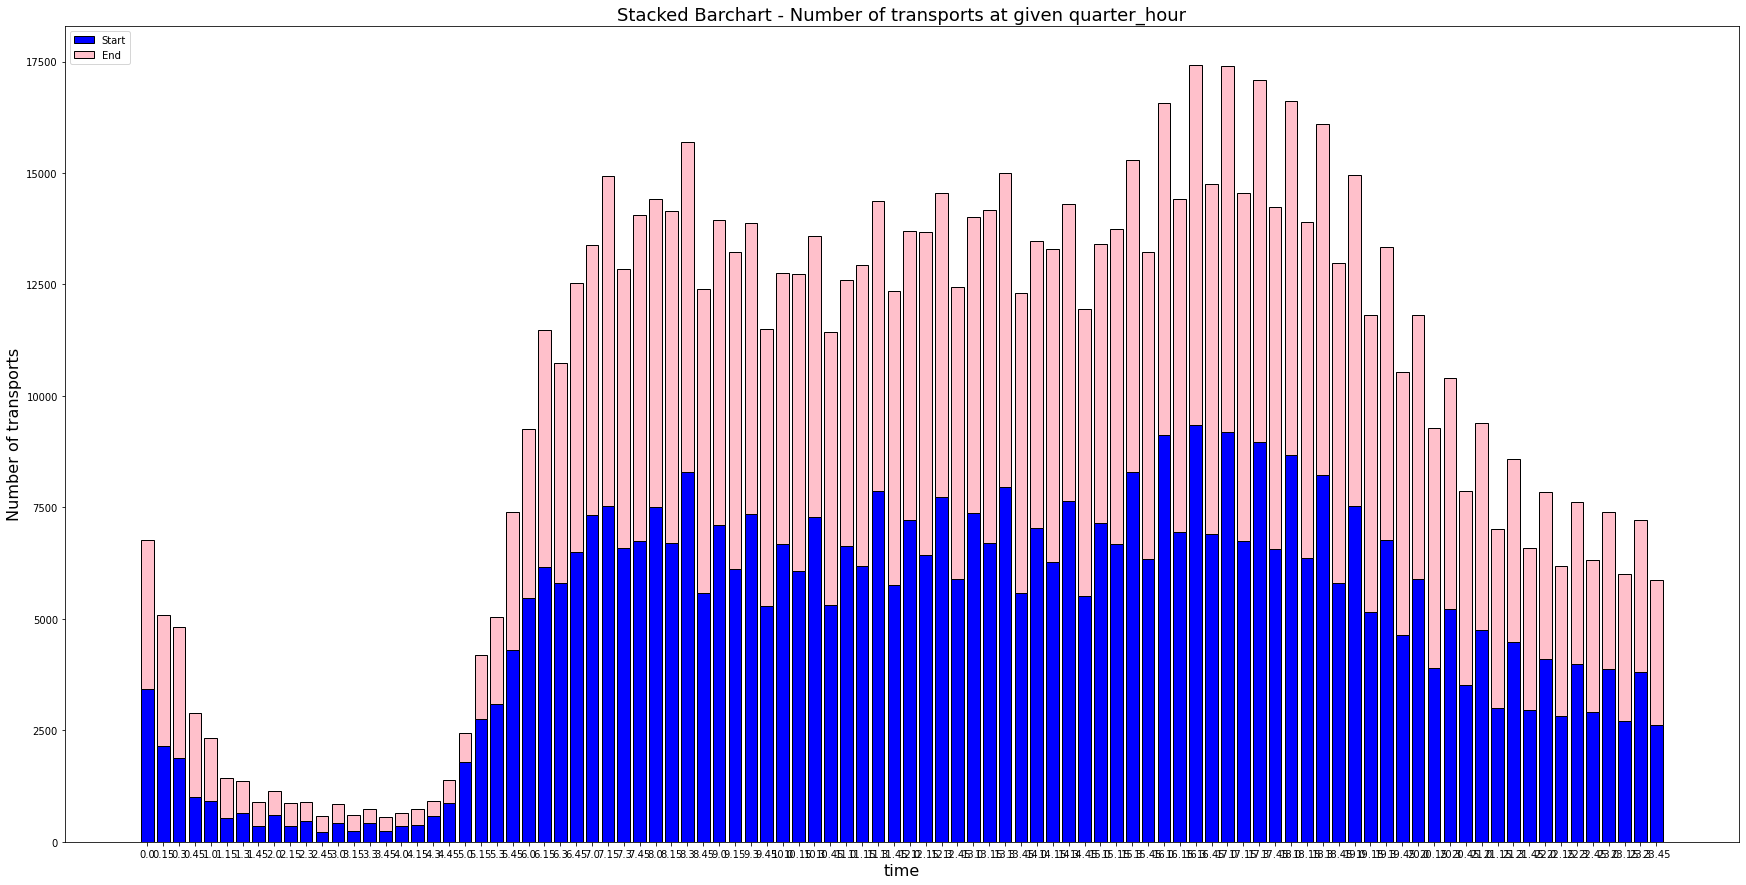

In [299]:
time=t.time.tolist()
classs=['Start','End']
pos = np.arange(t.shape[0])
starting_number=t.starting.tolist()
ending_number=t.ending.tolist()
 
plt.rcParams["figure.figsize"] = (30,15)

plt.bar(pos,starting_number,color='blue',edgecolor='black')
plt.bar(pos,ending_number,color='pink',edgecolor='black',bottom=starting_number)
plt.xticks(pos, time)
plt.xlabel('time', fontsize=16)
plt.ylabel('Number of transports', fontsize=16)
plt.title('Stacked Barchart - Number of transports at given quarter_hour',fontsize=18)
plt.legend(classs,loc=2)
plt.show()

## Prepare the data for Stacked Barchart

In [321]:
# map into several transport types 
trains = ['ICE', 'TGV', 'RJ', 'EC', 'IC', 'IR', 'PE', 'RE', 'S', 'SN', 'R', 'ARZ', 'EXT', 'NJ', 'IRE','RJX', 'RB', 'CC','TER']
fun = ['FUN', 'PB']
metro = ['M']
bus = ['B', 'CAR', 'EXB']
ship = ['BAT']
tram = ['T', 'TE2']
lift = ['GB', 'ASC']
other = ['SL', 'BN', 'FAE', 'RUB', 'KB','BP', 'EN']

data['transport_type'][data.transport_type.isin(trains)] = 'train'
data['transport_type'][data.transport_type.isin(fun)] = 'fun'
data['transport_type'][data.transport_type.isin(metro)] = 'metro'
data['transport_type'][data.transport_type.isin(bus)] = 'bus'
data['transport_type'][data.transport_type.isin(ship)] = 'ship'
data['transport_type'][data.transport_type.isin(tram)] = 'tram'
data['transport_type'][data.transport_type.isin(lift)] = 'lift'
data['transport_type'][data.transport_type.isin(other)] = 'other'

In [457]:
tr_types = ['train','fun','metro','bus','ship','tram', 'lift', 'other']

In [300]:
# load GeoJSON file containing sectors
with open(DATAFOLDER + '/dd_geojson_switzerland.json') as f:
    js = json.load(f)
    
# construct point based on lon/lat returned by geocoder
def get_canton(js, lat, long):
    point = Point(lat, long)
   # check each polygon to see if it contains the point
    for feature in js['features']:
        polygon = shape(feature['geometry'])
        if polygon.contains(point):
            return feature['properties']['name']
    return 'not in switzerland'
get_canton(js, 7.655224, 47.597713)

'not in switzerland'

In [458]:
tr_res = data[['start_station_ID','end_station_ID', 'transport_type','passing_station_IDS' ]]

In [459]:
def create_unique_station_type(tr_res,tr_types):
    data = {}
    for type_ in tr_types:
        tr = tr_res[tr_res.transport_type == type_].passing_station_IDS.tolist()
        tr_set = {'800000'}
        for i in range(len(tr)):
            tr_set.update(tr[i])
        res = dict.fromkeys(tr_set, type_) 
        data.update(res)
    return data

In [461]:
tr_res = pd.DataFrame(create_unique_station_type(tr_res,tr_types).items(), columns= ['station_id', 'transport_type'])

Text(0.5, 0, 'Number of schedules for different route types')

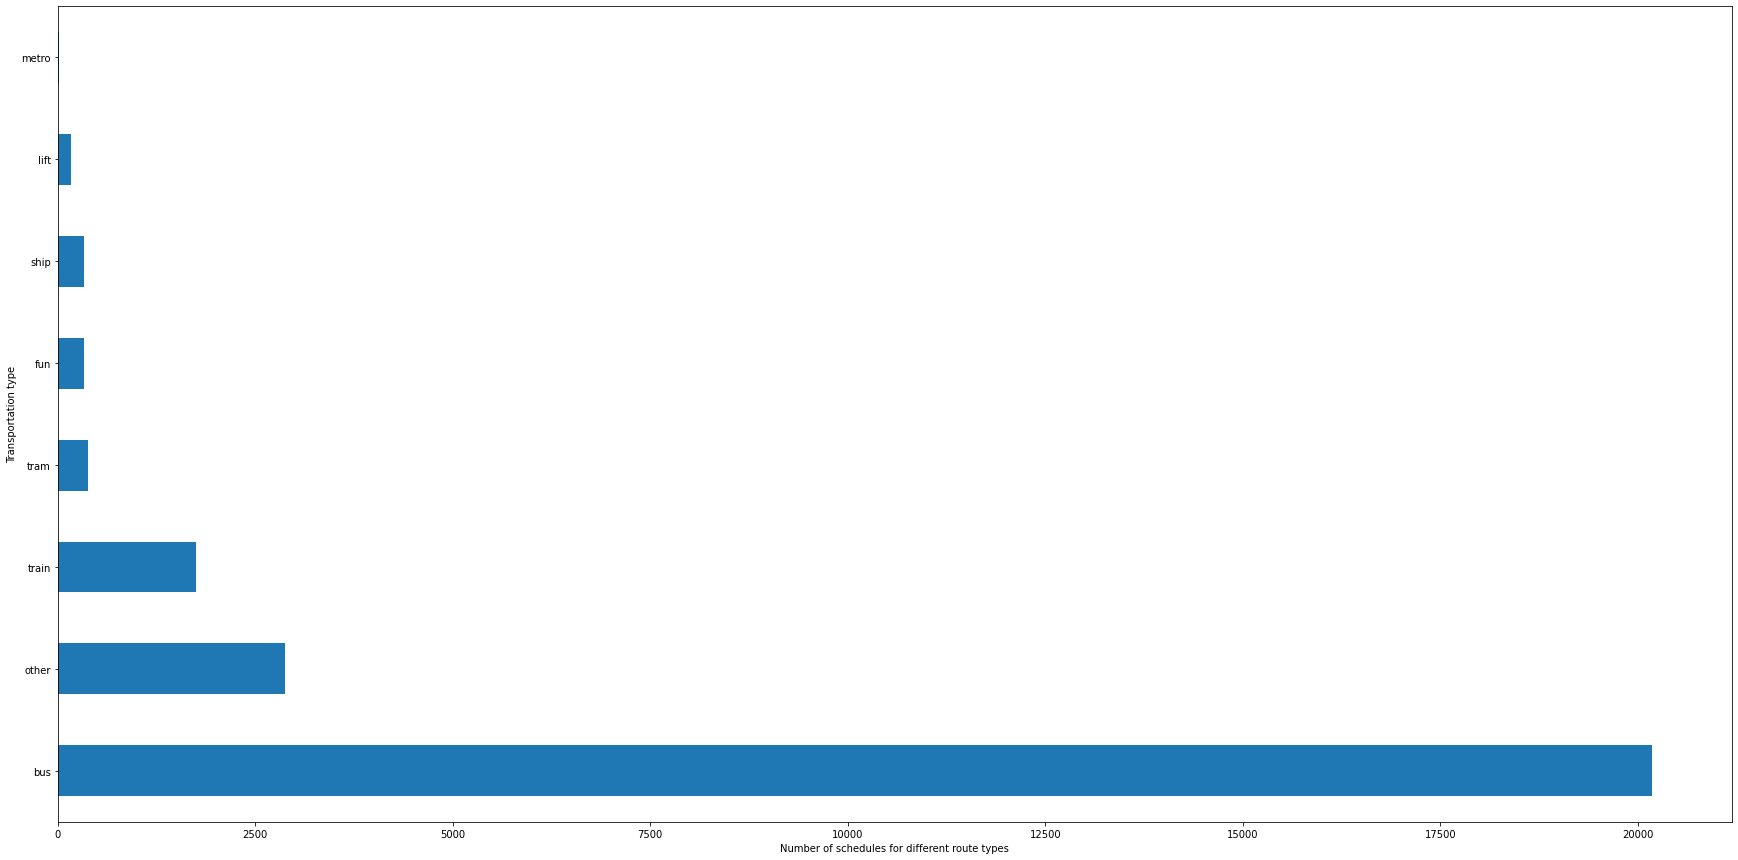

In [462]:
ax = tr_res.transport_type.value_counts()[:10].plot.barh(legend=False)
ax.set_ylabel('Transportation type')
ax.set_xlabel('Number of schedules for different route types')

In [464]:
with open(DATAFOLDER + "/2020_03_01/BFKOORD_GEO") as stations:
    text = stations.read()
result = text.split('\n')
st_id, lat, longt, number, name = ([] for i in range(5))
for i in range(len(result) - 1):
    each = result[i].split()
    st_id.append(each[0])
    lat.append(each[1])
    longt.append(each[2])
    number.append(each[3])
    name.append(' '.join(each[5:])) 
station_info = {'station_id': st_id, 'latitude': lat,'longitude': longt
               ,'number': number,'station_name': name}
stations = pd.DataFrame.from_dict(station_info)

In [465]:
stations.latitude= stations.latitude.astype(float)
stations.longitude= stations.longitude.astype(float)

In [466]:
stations['canton'] = stations.apply(lambda row: get_canton(js, row.latitude, row.longitude), axis = 1)

In [467]:
suisse_stations = stations[stations.canton != 'not in switzerland']

In [468]:
station_name_id_map = pd.merge(tr_res, suisse_stations, how='inner', left_on='station_id', right_on='station_id')

In [469]:
print(tr_res.shape)
print(station_name_id_map.shape)

(26026, 2)
(24601, 7)


In [470]:
canton_tt_data = station_name_id_map.groupby(['canton', 'transport_type']).size().reset_index(name='counts')

In [471]:
canton_tt_data.head()

,canton,transport_type,counts
0,Aargau,bus,1270
1,Aargau,other,78
2,Aargau,ship,6
3,Aargau,train,25
4,Appenzell Ausserrhoden,bus,202


In [603]:
cantons = canton_tt_data.canton.unique().tolist()
tt = np.sort(canton_tt_data.transport_type.unique().tolist())

In [604]:
import itertools
a = []
for i in itertools.product(cantons, tt):
    a.append([i[0], i[1]])
to_merge = pd.DataFrame(a, columns = ['Canton', 'Transport_type'])

In [605]:
tt_data = pd.merge(to_merge, canton_tt_data, how='left', right_on =['canton', 'transport_type'], left_on=['Canton', 'Transport_type'])[['Canton', 'Transport_type','counts']]
tt_data.fillna(0, inplace = True)

In [606]:
new_df = canton_tt_data.groupby(['canton'], sort=True).sum().reset_index()
new_df = new_df.sort_values(by = ['counts'], ascending=[False])
sorter = new_df.canton.tolist()

In [607]:
tt = pd.merge(new_df, tt_data, how = 'left', left_on = 'canton', right_on = 'Canton')[['canton', 'Transport_type', 'counts_y']]

In [608]:
dumm = pd.get_dummies(tt.Transport_type)
a = pd.concat([tt, dumm], axis=1)

In [478]:
a.bus = a.apply(lambda x: x.counts_y * x.bus, axis=1)
a.fun = a.apply(lambda x: x.counts_y * x.fun, axis=1)
a.lift = a.apply(lambda x: x.counts_y * x.lift, axis=1)
a.metro = a.apply(lambda x: x.counts_y * x.metro, axis=1)
a.other = a.apply(lambda x: x.counts_y * x.other, axis=1)
a.ship = a.apply(lambda x: x.counts_y * x.ship, axis=1)
a.train = a.apply(lambda x: x.counts_y * x.train, axis=1)
a.tram = a.apply(lambda x: x.counts_y * x.tram, axis=1)

In [481]:
b = a.groupby(['canton']).sum().reset_index()[['canton','bus', 'fun', 'lift', 'metro', 'other', 'ship', 'train', 'tram']]
b.to_csv(DATAFOLDER + '/data_figures/stacked_bar_chart.csv', index=False)

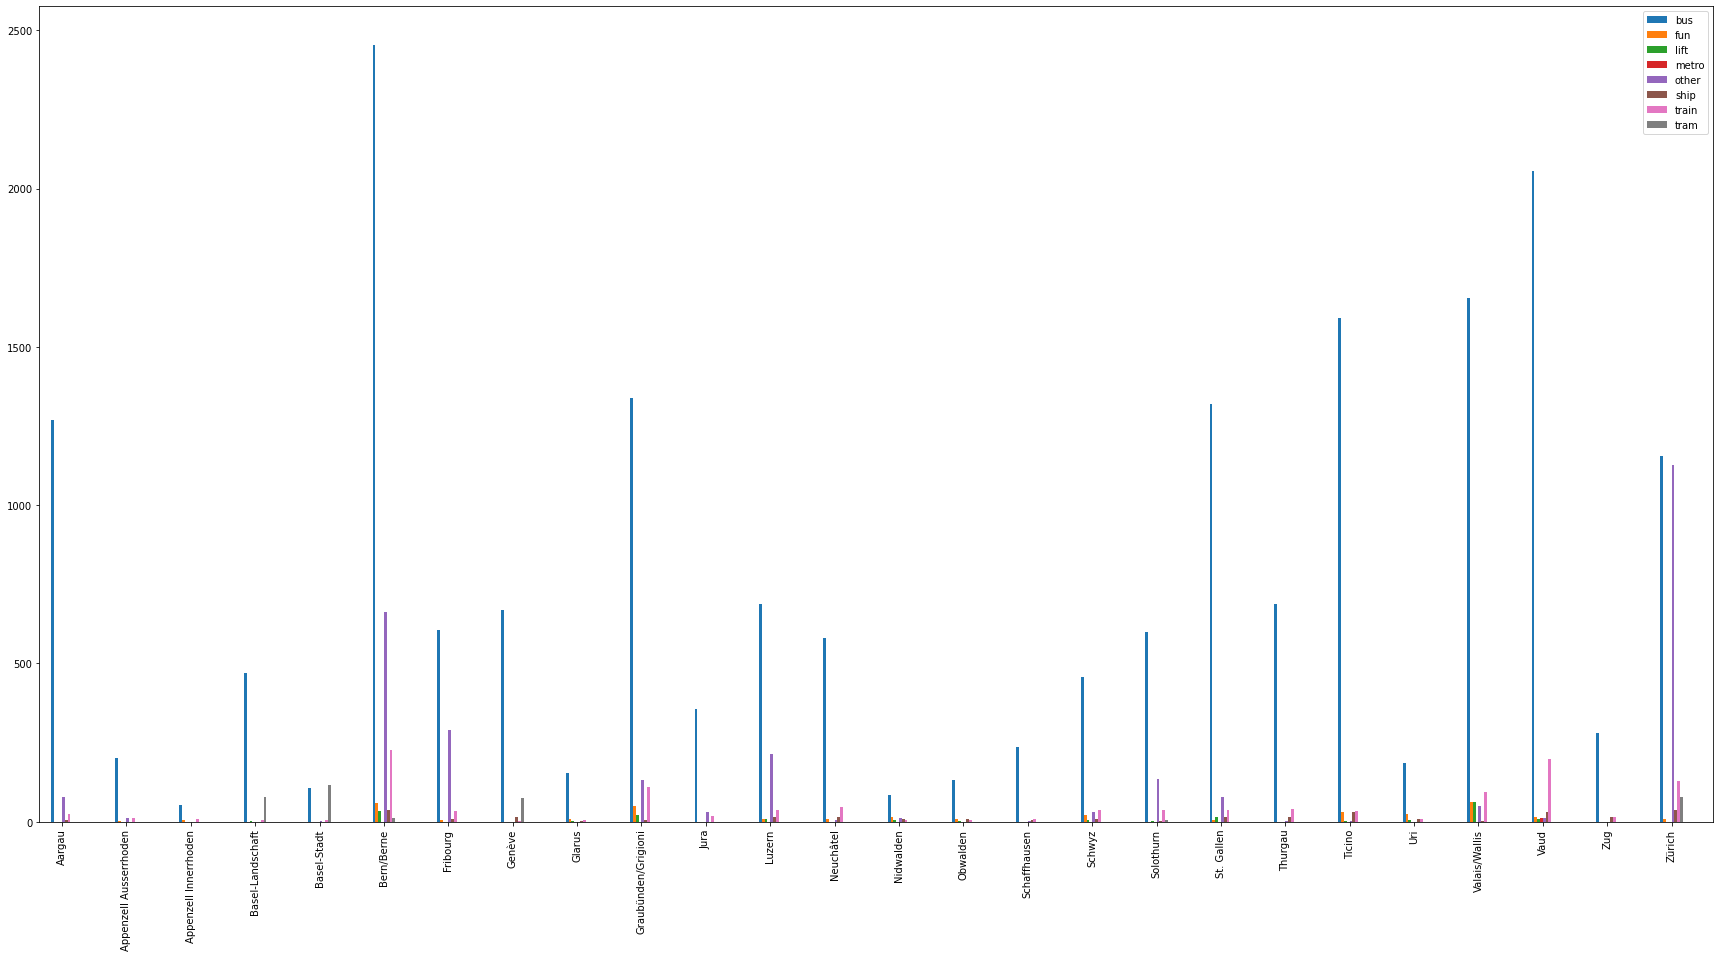

In [480]:
width = .35 # width of a bar

m1_t = b[['bus','fun', 'lift', 'metro', 'other', 'ship', 'train', 'tram']]

m1_t.plot(kind='bar', width = width)

ax = plt.gca()
plt.xlim([-width, len(m1_t['fun'])-width])
ax.set_xticklabels(b.canton.tolist())

plt.show()

## Prepare the data for D3. force

In [482]:
df = pd.read_excel(DATAFOLDER +'/passengers2018.xlsx')

# get the size of the data set
print("The data contains passenger capacity information for {} stations in Switzerland.".format(df.shape[0]))
# get some sample of the data
df.head()

The data contains passenger capacity information for 906 stations in Switzerland.


,Code,Bahnhof_Haltestelle,Kanton,Eigner,DTV_2018,DWV_2018,DNWV_2018,Bemerkungen,Remarques,Note,Remarks
0,AA,Aarau,AG,SBB,37900,44800,22700,Ohne AVA.,Sans AVA.,Senza AVA.,Without AVA.
1,AAT,Aathal,ZH,SBB,740,800,610,NaN,NaN,NaN,NaN
2,ABO,Aarburg-Oftringen,AG,SBB,2500,3000,1300,NaN,NaN,NaN,NaN
3,ACLA,Acla da Fontauna,GR,MGB,90,90,80,NaN,NaN,NaN,NaN
4,AD,Aadorf,TG,SBB,1700,2000,1000,Durchschnittswert 2018 durch Streckensperrung ...,Valeur moyenne 2018 à la baisse en raison de l...,Valore medio 2018 compromesso dallo sbarrament...,Average value for 2018 impacted by line closure.


In [483]:
df_p = df.fillna(value=0)
df_p = df_p.rename(columns = {'Code':'station_code','Bahnhof_Haltestelle':'station_name', 'Kanton':'canton'})
big_stations = df_p.iloc[:,0:3]

In [516]:
nodes = pd.merge(big_stations, suisse_stations, how='inner', left_on = 'station_name', right_on = 'station_name')[['station_name', 
                                                                                                        'canton_x', 'station_id']]

In [ ]:
def create_links(passing_st_ids):
    """Create the dict of links with frequency values"""
    links = []
    info = {}
    for i in range(len(passing_st_ids)):
        sorted_ids = sorted(passing_st_ids[i]) 
        for j in range(len(sorted_ids)):
            for k in range(j+1, len(sorted_ids)):
                info = {}
                info['source'] = sorted_ids[j]
                info['target'] = sorted_ids[k]
                info['value'] = 1
                links.append(info)
    return links
#links = create_links(passing_st_ids)
#a = pd.DataFrame.from_dict(links)
#d = a.groupby(['source','target'])['value'].sum().reset_index()

In [485]:
links = pd.read_csv(DATAFOLDER + '/data_figures/links.csv')

In [517]:
nodes['station_Id_int'] = nodes.apply(lambda x: int(x['station_id']), axis = 1).tolist()

In [548]:
a = pd.merge(links, nodes, how ='inner', left_on = 'source', right_on = 'station_Id_int')[['station_name','source','target', 'value' ]]
b = pd.merge(a,nodes, how ='inner', left_on = 'target', right_on = 'station_Id_int' )

In [549]:
# take those nodes whose edge connection value is >100
b = b[b.value > 150]


In [550]:
b.head()

,station_name_x,source,target,value,station_name_y,canton_x,station_id,station_Id_int
1,Basel SBB,8500010,8500020,256,Muttenz,BL,8500020,8500020
2,Basel SBB,8500010,8500021,238,Pratteln,BL,8500021,8500021
3,Muttenz,8500020,8500021,237,Pratteln,BL,8500021,8500021
7,Basel SBB,8500010,8500023,368,Liestal,BL,8500023,8500023
21,Lausen,8500024,8500025,151,Itingen,BL,8500025,8500025


In [551]:
c = b.source.tolist() + b.target.tolist()

In [554]:
nodes = nodes[nodes['station_Id_int'].isin(c)]

In [593]:
link = b[['station_name_x', 'station_name_y', 'value']]

In [594]:
link.rename(columns={'station_name_x': 'source', 'station_name_y' : 'target'}, inplace = True)

In [595]:
canton_map = {}
cantons = nodes.canton_x.unique()
for i in range(len(cantons)):
    canton_map.update({cantons[i] : i})

In [596]:
# scale the edge weight
link.value  = round(link.value.divide(100)).astype(int)
link.head()

,source,target,value
1,Basel SBB,Muttenz,3
2,Basel SBB,Pratteln,2
3,Muttenz,Pratteln,2
7,Basel SBB,Liestal,4
21,Lausen,Itingen,2


In [597]:
nodes['group'] = nodes.apply(lambda x: canton_map[x.canton_x], axis = 1)

In [598]:
nodes.rename(columns={'station_name': 'id'}, inplace = True)

In [599]:
n = nodes[['id', 'group']].to_dict('records')
l = link.to_dict('records')

In [600]:
force = {}
force['nodes'] = n
force['links'] = l

In [601]:
force

{'nodes': [{'id': 'Aarau', 'group': 0},
  {'id': 'Aarburg-Oftringen', 'group': 0},
  {'id': 'Aadorf', 'group': 1},
  {'id': 'Alpnach Dorf', 'group': 2},
  {'id': 'Aesch', 'group': 3},
  {'id': 'Affoltern am Albis', 'group': 4},
  {'id': 'Aigle', 'group': 5},
  {'id': 'Allaman', 'group': 5},
  {'id': 'Altstätten SG', 'group': 6},
  {'id': 'Altendorf', 'group': 7},
  {'id': 'Andelfingen', 'group': 4},
  {'id': 'Alpnachstad', 'group': 2},
  {'id': 'Au ZH', 'group': 4},
  {'id': 'Au SG', 'group': 6},
  {'id': 'Amriswil', 'group': 1},
  {'id': 'Baar', 'group': 8},
  {'id': 'Baar Lindenpark', 'group': 8},
  {'id': 'Baar Neufeld', 'group': 8},
  {'id': 'Balerna', 'group': 9},
  {'id': 'Baden', 'group': 0},
  {'id': 'Burgdorf', 'group': 10},
  {'id': 'Bellinzona', 'group': 9},
  {'id': 'Berg', 'group': 1},
  {'id': 'Bex', 'group': 5},
  {'id': 'Brugg AG', 'group': 0},
  {'id': 'Bürglen', 'group': 1},
  {'id': 'Biel/Bienne', 'group': 10},
  {'id': 'Biberbrugg', 'group': 7},
  {'id': 'Birmensdor

In [602]:
import json
with open(DATAFOLDER + '/data_figures/force.json', 'w') as fp:
    json.dump(force, fp)